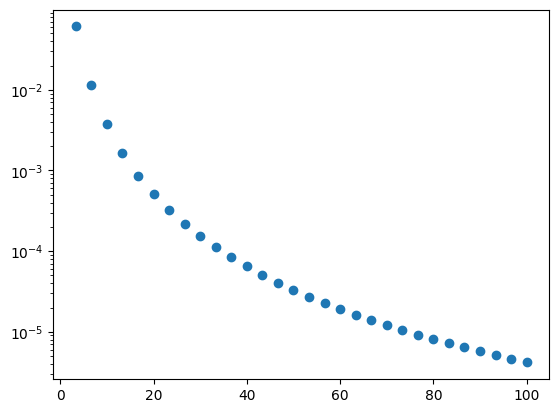

In [38]:
import numpy as np
import matplotlib.pyplot as plt

"""
Calculer le champ sur une ligne
===============================

La ligne est verticale (en y) et je regarde sur l'axe (y=0) en x

J'ai une ligne de charges de longueur L, discrétisée en N sous-éléments de longueur L/(N-1)
(le N-1 vient du fait que j'inclus L/2 dans la liste de valeurs).

Je veux une charge totale qui ne change pas en terme du nombre N,
donc si q = L * densité, alors densité=q/L, et dq = densité * dl,
puisque la ligne est L est en y' (en y et c'est une source), dl = dy'

"""

L = 10       # Grandeur de la ligne en y
N = 101        # Nombre de sources discrètes sur la ligne
Y_prime = np.linspace(-L/2, L/2, N, endpoint=False ) # Valeurs en y sur la ligne
dy_prime = Y_prime[1] - Y_prime[0]

q_total = 1
densite_charge = q_total/L
dq = densite_charge * dy_prime

distance = 100
M = 30
X = np.linspace(distance/M, distance, M)
V_ligne = np.zeros(M) # Potentiel sur la ligne x

for i, x in enumerate(X):
  q_total_calculee = 0

  for y_prime in Y_prime:
    r = np.sqrt(x*x+y_prime*y_prime)
    V_ligne[i] += dq/r

    q_total_calculee += densite_charge*dy_prime

  """
  Je voyais une différence entre le monopole et une charge L<<<1
  J'étais convaincu que j'avais une erreur de calcul.
  Auparavant, je prenais:

  Y_prime = np.linspace(-L/2, L/2, N, endpoint=True )

  mais en faisant la boucle

  for y_prime in Y_prime:
    bla bla

  je me retrouvais à additionner un petit dy_prime de plus
  car le dernier y' dépassait L/2 ce qui me donnait une charge 1% plus élevée.
  J'ai mis cette vérification ci-dessous et j'ai trouvé l'erreur, que j'ai
  corrigée.
  """
  assert np.isclose(q_total_calculee, q_total)

  # print(x, V_ligne[i])

# plt.scatter(X, V_ligne, 20, "k")
# plt.plot(X, q_total /X)
plt.scatter(X, abs(V_ligne - q_total /X))
plt.yscale('log')
plt.show()
